In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

In [4]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [5]:
sql = "SELECT * FROM IBM"

In [6]:
df = pd.read_sql(sql, con, parse_dates="data", index_col="date")

In [7]:
df.head()

,open,high,low,close,volume
date,,,,,
2024-11-18T00:00:00,207.00,208.4150,205.3701,208.09,3406045.0
2024-11-15T00:00:00,207.46,208.4900,204.0700,204.99,3986460.0
2024-11-14T00:00:00,210.00,210.4999,206.3500,208.99,6372853.0
2024-11-13T00:00:00,209.50,211.4100,209.0701,210.92,3247830.0
2024-11-12T00:00:00,211.90,213.0300,209.0600,210.86,2818216.0


In [8]:
# set index type to datetime index
df.index = pd.to_datetime(df.index, format='ISO8601')
df.sort_index(inplace=True)

In [9]:
df.head()

,open,high,low,close,volume
date,,,,,
1999-11-01,98.50,98.81,96.37,96.75,9551800.0
1999-11-02,96.75,96.81,93.69,94.81,11105400.0
1999-11-03,95.87,95.94,93.50,94.37,10369100.0
1999-11-04,94.44,94.44,90.00,91.56,16697600.0
1999-11-05,92.75,92.94,90.19,90.25,13737600.0


# Feature engineering

### Price-based features

In [10]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['price_change_pct'] = df['close'].pct_change()

price_grp =['log_returns','price_change_pct']

### Volume-based features

In [11]:
df['log_volume_change'] = np.log(df["volume"])-np.log(df["volume"].shift(1))
df['volume_change_pct'] = df['volume'].pct_change()
df['normalized_volume'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
df['VMA_14'] = df['volume'].rolling(window=14).mean()
df['volume_std'] = df['volume'].rolling(window=14).std()

volume_grp =['log_volume_change','volume_change_pct','normalized_volume']
rolling_volume_grp = ['VMA_14','volume_std']

### Trading range

In [12]:
df["log_trading_range"] = np.log(df["high"])-np.log(df["low"])

# Calculate True Range (TR)
df['TR'] = pd.concat([
    df['high'] - df['low'],
    abs(df['high'] - df['close'].shift(1)),
    abs(df['low'] - df['close'].shift(1))
], axis=1).max(axis=1)

# Calculate the ATR (14-period SMA of TR)
df['ATR_14'] = df['TR'].rolling(window=14).mean()

TR_grp =['log_trading_range','TR','ATR_14']

### Technical indicators/ Rolling Statistics

In [13]:
# Moving averages
MA_grp = []
for period in [5, 10, 20, 50]:
        df[f'MA_{period}'] = df['close'].rolling(window=period).mean()
        MA_grp.append(f'MA_{period}')

In [14]:
# RSI
def calculate_rsi(data, period=14):
    """
    Calculates the RSI for a given pandas Series or DataFrame.
    """

    # Calculate price changes
    delta = data.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and loss using a rolling window
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    # Calculate relative strength
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi
df['RSI'] = calculate_rsi(df['close'])
RSI_grp =['RSI']

In [15]:
# Bollinger bands
# Calculate the 20-period Simple Moving Average (SMA)
df['BB_middle'] = df['close'].rolling(window=20).mean()

# Calculate the 20-period Standard Deviation (SD)
BB_std = df['close'].rolling(window=20).std()

# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
df['BB_upper'] = df['BB_middle'] + 2 * BB_std
df['BB_lower'] = df['BB_middle'] - 2 * BB_std

BB_grp = ['BB_upper', 'BB_middle', 'BB_lower']

In [16]:
# Moving Average Convergence Divergence MACD
# Calculate the 12-day and 26-day EMA
EMA_12 = df['close'].ewm(span=12, adjust=False).mean()
EMA_26 = df['close'].ewm(span=26, adjust=False).mean()

# Calculate the MACD Line
df['MACD'] = EMA_12 - EMA_26

# Calculate the Signal Line (9-day EMA of MACD)
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate the MACD Histogram
df['MACD_hist'] = df['MACD'] - df['MACD_signal']

MACD_grp = ['MACD','MACD_signal', 'MACD_hist']

### Lagged features

In [17]:
# Volume Lagged features
volume_lag_grp = []
for feature in ['log_volume_change','volume_change_pct','normalized_volume']:
        for lag in [1, 2, 3]:
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            volume_lag_grp.append(f'{feature}_lag_{lag}')
            

In [18]:
# Price Lagged features
price_lag_grp = []
for feature in ['log_returns','price_change_pct','normalized_volume']:
        for lag in [1, 2, 3]:
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            price_lag_grp.append(f'{feature}_lag_{lag}')
            

### Rolling volatility/ Target

In [19]:
df["rolling_volatility"] = df["log_returns"].rolling(window=14).std()

In [20]:
df.dropna(inplace=True)

## Features and Target

In [21]:
df = df.drop(columns=['open', 'high', 'low', 'close', 'volume'])

In [22]:
features = df.columns
features

Index(['log_returns', 'price_change_pct', 'log_volume_change',
       'volume_change_pct', 'normalized_volume', 'VMA_14', 'volume_std',
       'log_trading_range', 'TR', 'ATR_14', 'MA_5', 'MA_10', 'MA_20', 'MA_50',
       'RSI', 'BB_middle', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal',
       'MACD_hist', 'log_volume_change_lag_1', 'log_volume_change_lag_2',
       'log_volume_change_lag_3', 'volume_change_pct_lag_1',
       'volume_change_pct_lag_2', 'volume_change_pct_lag_3',
       'normalized_volume_lag_1', 'normalized_volume_lag_2',
       'normalized_volume_lag_3', 'log_returns_lag_1', 'log_returns_lag_2',
       'log_returns_lag_3', 'price_change_pct_lag_1', 'price_change_pct_lag_2',
       'price_change_pct_lag_3', 'rolling_volatility'],
      dtype='object')

In [23]:
target = df['rolling_volatility']

# Feature selection

### Correlation with target

In [24]:
def corr_with_target(feature_grp):
    correlations = {}
    for column in feature_grp:
        corr, _ = spearmanr(df[column], target)
        correlations[column] = abs(corr)
    correlations = dict(sorted(correlations.items(), key=lambda item: item[1]))
    return correlations

In [25]:
def mi_scores(feature_grp):
    mi_scores = mutual_info_regression(df[feature_grp], target)
    mi_scores = dict(zip(df[feature_grp].columns, mi_scores))
    mi_scores=dict(sorted(mi_scores.items(), key=lambda item: item[1]))
    return mi_scores

In [26]:
to_drop = []

In [27]:
cor = corr_with_target(price_grp)
to_drop.extend(list(cor.keys())[:-1])

In [28]:
cor = corr_with_target(volume_grp)
to_drop.extend(list(cor.keys())[:-1])

In [29]:
cor = corr_with_target(rolling_volume_grp)
to_drop.extend(list(cor.keys())[:-1])

In [30]:
cor = corr_with_target(rolling_volume_grp)
to_drop.extend(list(cor.keys())[:-1])

In [31]:
cor = corr_with_target(TR_grp)
to_drop.extend(list(cor.keys())[:-1])

In [32]:
cor = corr_with_target(MA_grp)
to_drop.extend(list(cor.keys())[:-1])

In [33]:
cor = corr_with_target(RSI_grp)
to_drop.extend(list(cor.keys())[:-1])

In [34]:
cor = corr_with_target(BB_grp)
to_drop.extend(list(cor.keys())[:-1])

In [35]:
cor = corr_with_target(MACD_grp)
to_drop.extend(list(cor.keys())[:-1])

In [36]:
cor = corr_with_target(volume_lag_grp)
to_drop.extend(list(cor.keys())[:-1])

In [37]:
cor = corr_with_target(price_lag_grp)
to_drop.extend(list(cor.keys())[:-1])

In [38]:
to_drop

['log_returns',
 'log_volume_change',
 'volume_change_pct',
 'volume_std',
 'volume_std',
 'TR',
 'log_trading_range',
 'MA_50',
 'MA_20',
 'MA_10',
 'BB_upper',
 'BB_middle',
 'MACD_hist',
 'MACD',
 'log_volume_change_lag_3',
 'volume_change_pct_lag_3',
 'log_volume_change_lag_2',
 'volume_change_pct_lag_2',
 'log_volume_change_lag_1',
 'volume_change_pct_lag_1',
 'normalized_volume_lag_1',
 'normalized_volume_lag_2',
 'log_returns_lag_2',
 'price_change_pct_lag_2',
 'log_returns_lag_3',
 'price_change_pct_lag_3',
 'log_returns_lag_1',
 'price_change_pct_lag_1',
 'normalized_volume_lag_1',
 'normalized_volume_lag_2']

In [39]:
df = df.drop(columns=to_drop)

### Multicolinearity analysis

In [40]:
def remove_correlated_features(df, correlation_threshold=0.8):
    correlation_matrix = df.corr().abs()
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
    return df.drop(columns=to_drop)



In [41]:
df = remove_correlated_features(df)

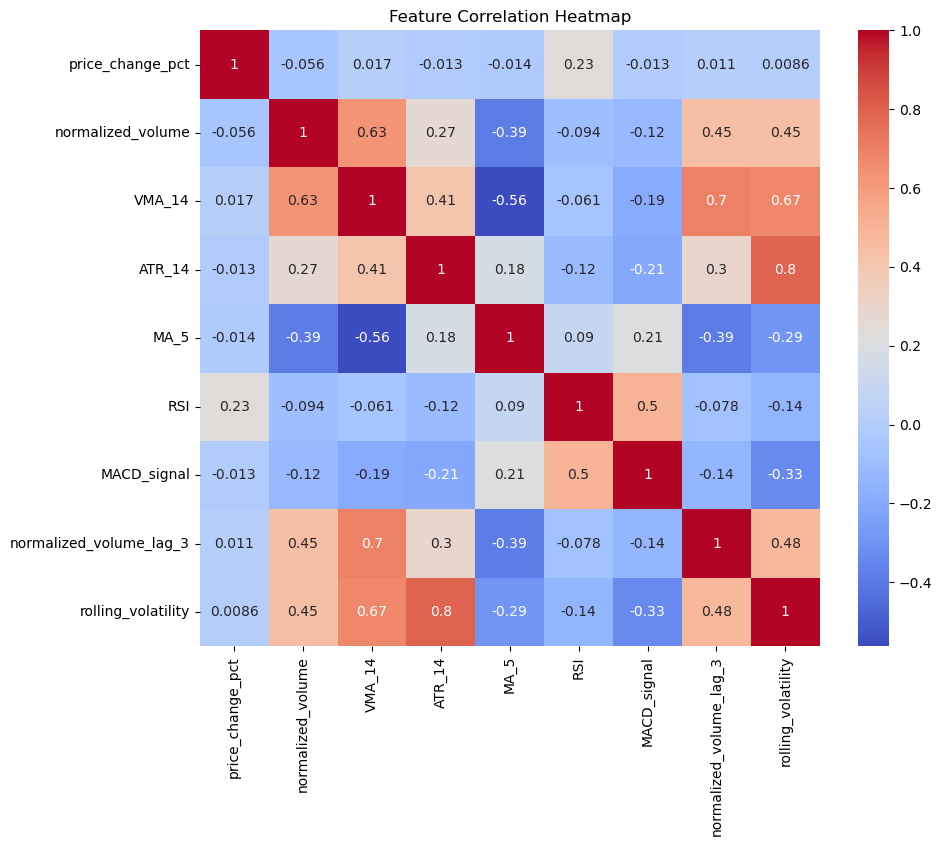

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check feature correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [43]:
df.head()

,price_change_pct,normalized_volume,VMA_14,ATR_14,MA_5,RSI,MACD_signal,normalized_volume_lag_3,rolling_volatility
date,,,,,,,,,
2000-01-11,0.008475,0.599835,6.635564e+06,4.212143,116.100,64.859438,2.234557,0.629734,0.027439
2000-01-12,0.004202,0.275527,6.835436e+06,4.315000,116.800,70.346780,2.392315,1.807737,0.026495
2000-01-13,-0.010460,0.786748,7.118364e+06,4.515714,117.650,66.666667,2.530511,0.802153,0.026918
2000-01-14,0.011586,1.534796,7.633786e+06,4.796429,118.874,66.941298,2.665292,0.599835,0.026934
2000-01-18,-0.032352,0.530273,7.888129e+06,5.015000,118.424,59.016393,2.723048,0.275527,0.028881


In [44]:
target

date
2000-01-11    0.027439
2000-01-12    0.026495
2000-01-13    0.026918
2000-01-14    0.026934
2000-01-18    0.028881
                ...   
2024-11-12    0.021136
2024-11-13    0.013481
2024-11-14    0.012971
2024-11-15    0.013704
2024-11-18    0.014205
Name: rolling_volatility, Length: 6254, dtype: float64

# LSTM model

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as k
import os
import random

## Set seed for reproducible results

In [46]:
# import random
# import numpy as np
# import tensorflow as tf

seed_value = 13

# Set random seeds
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# # Optionally force deterministic behavior (if using GPUs)
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU for deterministic behavior

# Optional: Ensure deterministic operations in TensorFlow
tf.config.experimental.enable_op_determinism()


## Train-test split

In [47]:
cut_off = int(len(df)*0.8)
df_train = df[:cut_off]
df_test = df[cut_off:]

In [48]:
# Function to create LSTM dataset
def create_lstm_dataset(dataset, time_steps=4):
#     features = dataset.columns
    
#     Normalize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    X, y = [], []
    
    # Create sliding window
    for i in range(len(scaled_data) - time_steps):
        # X: Input sequence of time_steps
        X.append(scaled_data[i:i+time_steps])
        
        # y: Next time step's closing price
        y.append(scaled_data[i+time_steps][-1]) 
        
    
    return np.array(X), np.array(y), scaler

In [49]:
# Generate training data
time_steps = 7
X_train, y_train, scaler = create_lstm_dataset(df_train, time_steps=time_steps)

In [50]:
# Get the number of features
data_dim = X_train.shape[2]
data_dim

9

In [51]:
# Build the LSTM model
model = Sequential([
    LSTM(units=100, input_shape=(time_steps, data_dim)),
    Dense(units=1)
])

In [52]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [53]:
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,            # Number of epochs with no improvement
    min_delta=0.001,        # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restore model weights from best epoch
)

In [54]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=100,
    validation_split=0.3,
    batch_size=32, 
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/100


2025-01-04 13:06:35.804393: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-01-04 13:06:35.804635: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9015 - root_mean_squared_error: 0.8948 - val_loss: 0.2040 - val_root_mean_squared_error: 0.4517
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1852 - root_mean_squared_error: 0.4223 - val_loss: 0.1548 - val_root_mean_squared_error: 0.3934
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 - root_mean_squared_error: 0.3656 - val_loss: 0.1114 - val_root_mean_squared_error: 0.3338
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0992 - root_mean_squared_error: 0.3094 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2941
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0802 - root_mean_squared_error: 0.2785 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2783
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 - root_mean_squared_error: 0.2679 - val_loss: 0.0713 - val_root_mean_squared_error: 0.2670
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

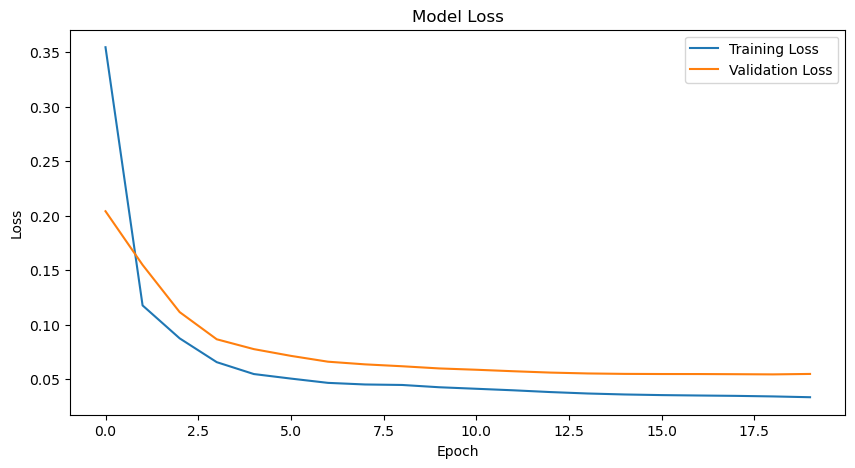

In [55]:
# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# Generate testdata
# time_steps = 4
X_test, y_test, scaler = create_lstm_dataset(df_test, time_steps=time_steps)

In [57]:
pred = model.predict(X_test)

146/196 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step

2025-01-04 13:06:43.417788: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-01-04 13:06:43.418037: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


In [58]:
mean_squared_error(y_test, pred)

0.04092836541740335

In [59]:
r2_score(y_test, pred)

0.9589884519949755

In [60]:
mean_absolute_error(y_test,pred)

0.12269012064669915